In [1]:
from datetime import datetime
import os
import itertools
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sklearn.preprocessing import OneHotEncoder
import torch
from tqdm import tqdm

from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.dataprocessing.transformers import InvertibleMapper
from darts.dataprocessing.transformers.scaler import Scaler
from darts.models import MovingAverageFilter
from darts.models import TiDEModel
from darts.metrics import mae, mse
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%matplotlib inline

/Users/sho/git-portfolio/sales_forecast_walmart/venv/lib/python3.9/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
class Config:
    seed = 2023
    timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
    curr_dirpath = Path(os.getcwd())
    repo_dirpath = curr_dirpath / '../'
    dataset_dirpath = repo_dirpath / 'input'
    ts_identifier_col = 'store_item'
    ts_col = 'date'
    target_col = 'sales'

config = Config()

In [4]:
"""
id - the index of the row
date - the current date
store_nbr - the store
family - the product family
sales - number of sales in this family
onpromotion - the number of products on promotion in this family
"""
train_df = pd.read_csv(config.dataset_dirpath / "train.csv")

print(train_df.shape)
train_df.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [12]:
"""
For simplicity,
reduce the dataset size
"""
mask_store = train_df['store_nbr'].isin([1, 2, 3])
mask_family = train_df['family'].isin(['EGGS', 'BEVERAGES', 'BOOKS'])

_length = len(train_df)
train_df = train_df[mask_store & mask_family].reset_index(drop=True)
print(f"record length: {_length} --> {len(train_df)}")
print(train_df['store_nbr'].unique())
print(train_df['family'].unique())

record length: 3000888 --> 15156
[1 2 3]
['BEVERAGES' 'BOOKS' 'EGGS']


In [91]:
test_df = pd.read_csv(config.dataset_dirpath / "test.csv")

print(test_df.shape)
display(test_df.head())

"""
For simplicity, reduce the dataset size
"""
mask_store = test_df['store_nbr'].isin([1, 2, 3])
mask_family = test_df['family'].isin(['EGGS', 'BEVERAGES', 'BOOKS'])
_length = len(test_df)
test_df = test_df[mask_store & mask_family].reset_index(drop=True)
print(f"record length: {_length} --> {len(test_df)}")
print(test_df['store_nbr'].unique())
print(test_df['family'].unique())


test_df_dropped = test_df.drop(['onpromotion'], axis=1)
test_df_sorted = test_df_dropped.sort_values(by=['store_nbr','family'])
# display(test_df_sorted.head())

(28512, 5)


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


record length: 28512 --> 144
[1 2 3]
['BEVERAGES' 'BOOKS' 'EGGS']


In [92]:
"""
date - the date of the holiday
type - the type of holiday (Holiday, Event, Transfer (see transferred column), Additional, Bridge, Work Day)
locale - the scope of the event (Local, Regional, National)
locale_name - the city where the event takes place
description - name of the event
transferred - whether the event has been transferred (moved to another day) or not
"""
event_df = pd.read_csv(config.dataset_dirpath / "holidays_events.csv")

print(event_df.shape)
event_df.head()

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [93]:
"""
daily oil price
"""
oil_df = pd.read_csv(config.dataset_dirpath / "oil.csv")

print(oil_df.shape)
oil_df.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [94]:
"""
store_nbr - the store
city - the city where the store is located
state - the state where the store is located
type - the type of the store
cluster - the number of similar stores in the vicinity
"""
store_df = pd.read_csv(config.dataset_dirpath / "stores.csv")

print(store_df.shape)
store_df.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [95]:
transaction_df = pd.read_csv(config.dataset_dirpath / "transactions.csv")

print(transaction_df.shape)
transaction_df.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [96]:
"""
Check for duplicate rows
"""
df_list = [train_df, event_df, oil_df, store_df]
for df in df_list:
    count_duplicate_rows = len(df)-len(df.drop_duplicates())
    print(f"There are {count_duplicate_rows} duplicate rows")

There are 0 duplicate rows
There are 0 duplicate rows
There are 0 duplicate rows
There are 0 duplicate rows


In [97]:
# """
# Reduce the amount of data for simplicity
# """
# train_df = train_df.loc[train_df["store"] <= 2]

## Preprocessing

unique name list for grouping

In [98]:
family_list = train_df['family'].unique()
# store_list = store_df['store_nbr'].unique()
store_list = train_df['store_nbr'].unique()
display(family_list)
display(store_list)

array(['BEVERAGES', 'BOOKS', 'EGGS'], dtype=object)

array([1, 2, 3])

Merge dataset

In [99]:
df = pd.merge(train_df, store_df, on='store_nbr')
df = df.sort_values(by=['store_nbr', 'family', 'date'])

In [100]:
df = df.astype({"store_nbr":'str', "family":'str', "city":'str',
                "state":'str', "type":'str', "cluster":'str'})

Keep timeseries based on `family`

In [101]:
group_col_list = ['store_nbr', 'family']

static_cov_col_list: List[str] = ['city', 'state', 'type', 'cluster']
past_cov_col_list: List[str] = []
future_cov_col_list: List[str] = []

In [102]:
"""
Prepare TimeSeries for Darts

Note
----
time_col: str: timeseries column name
group_cols, List[str]: individual time series are extracted by grouping `df` by `group_cols`
static_cols, List[str]: extract these additional columns as static covariates (without grouping)
values_cols, List[str]: timeseries value column name list
"""
series_dict = {}
for family in family_list:
    _df = df.loc[df['family'] == family, :]
    series_list: List = TimeSeries.from_group_dataframe(
        _df,
        time_col=config.ts_col,
        group_cols=group_col_list,
        static_cols=static_cov_col_list,
        value_cols=[config.target_col],
        freq='D',
        fill_missing_dates=True,
    )
    """
    Must to update
    """
    for series in series_list:
        """ float --> np.float32 """
        series = series.astype(float)
    """ need to sort series by stores """
    series_dict[family] = series_list

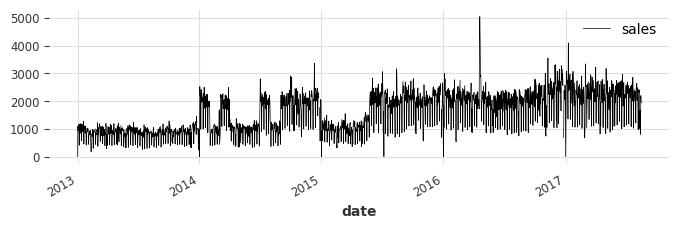

In [103]:
for family in series_dict:
    series_list = series_dict[family]
    for series in series_list:
        plt.figure(figsize=(8, 2))
        series.plot(label='sales', lw=0.5)
        plt.show()
        break
    break

Normalizing time series

In [104]:
pipeline_dict = {}
scaled_series_dict = {}
for family in series_dict:
    train_filter = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
    static_cov_transformer = StaticCovariatesTransformer(verbose=False, 
                                                        transformer_cat=OneHotEncoder(),
                                                        name="ENcoder")
    log_transformer = InvertibleMapper(np.log1p, 
                                    np.expm1, 
                                    verbose=False, 
                                    n_jobs=-1,
                                    name="Log-Transform")
    train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

    train_pipeline = Pipeline([train_filter,
                            static_cov_transformer,
                            log_transformer,
                            train_scaler])
    scaled_series_list = train_pipeline.fit_transform(series_dict[family])

    pipeline_dict[family] = train_pipeline
    scaled_series_dict[family] = scaled_series_list

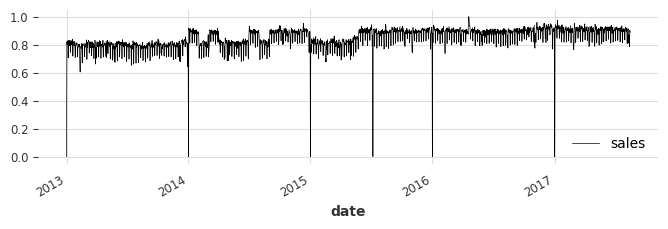

In [105]:
for family in scaled_series_dict:
    series_list = scaled_series_dict[family]
    for series in series_list:
        plt.figure(figsize=(8, 2))
        series.plot(label='sales', lw=0.5)
        plt.show()
        break
    break

### Covariates

Date

In [106]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

full_time_period = pd.date_range(start='2013-01-01', end='2017-08-31', freq='D')


year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
dayofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofyear")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")
weekofyear = datetime_attribute_timeseries(time_index = full_time_period, attribute="weekofyear")
timesteps = TimeSeries.from_times_and_values(times=full_time_period,
                                            values=np.arange(len(full_time_period)),
                                            columns=["linear_increase"])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(float)

In [107]:
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp('20170816'))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)

Oil

In [108]:
"""
Moving avarage
"""
oil_series = TimeSeries.from_dataframe(oil_df,
                                        time_col=config.ts_col,
                                        value_cols=['dcoilwtico'],
                                        freq='D')
oil_series = oil_series.astype(float)

# Transform
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")
oil_pipeline = Pipeline([oil_filler, oil_scaler])

oil_transformed = oil_pipeline.fit_transform(oil_series)

# Moving Averages for Oil Price
oil_moving_average_7 = MovingAverageFilter(window=7, centered=True)
oil_moving_average_28 = MovingAverageFilter(window=28, centered=True)

oil_moving_averages = []

ma_7 = oil_moving_average_7.filter(oil_transformed).astype(float)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="oil_ma_7")
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(float)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="oil_ma_28")
oil_moving_averages = ma_7.stack(ma_28)

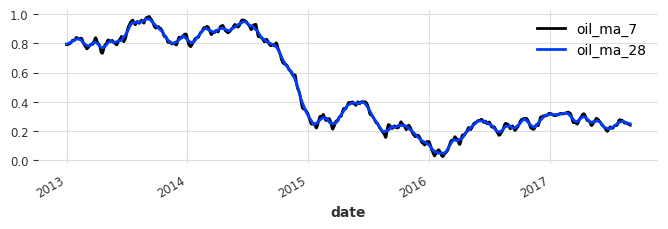

In [109]:
plt.figure(figsize=(8, 2))
oil_moving_averages.plot()
plt.show()

Holiday

In [110]:
def holiday_list(df_stores):

    listofseries = []

    for i in range(0,len(df_stores)):

            df_holiday_dummies = pd.DataFrame(columns=['date'])
            df_holiday_dummies["date"] = event_df["date"]
            
            df_holiday_dummies["national_holiday"] = np.where(((event_df["type"] == "Holiday") & (event_df["locale"] == "National")), 1, 0)

            df_holiday_dummies["earthquake_relief"] = np.where(event_df['description'].str.contains('Terremoto Manabi'), 1, 0)

            df_holiday_dummies["christmas"] = np.where(event_df['description'].str.contains('Navidad'), 1, 0)

            df_holiday_dummies["football_event"] = np.where(event_df['description'].str.contains('futbol'), 1, 0)

            df_holiday_dummies["national_event"] = np.where(((event_df["type"] == "Event") & (event_df["locale"] == "National") & (~event_df['description'].str.contains('Terremoto Manabi')) & (~event_df['description'].str.contains('futbol'))), 1, 0)

            df_holiday_dummies["work_day"] = np.where((event_df["type"] == "Work Day"), 1, 0)

            df_holiday_dummies["local_holiday"] = np.where(((event_df["type"] == "Holiday") & ((event_df["locale_name"] == df_stores['state'][i]) | (event_df["locale_name"] == df_stores['city'][i]))), 1, 0)

            listofseries.append(df_holiday_dummies)

    return listofseries

In [111]:
def remove_0_and_duplicates(holiday_list):

    listofseries = []
    
    for i in range(0,len(holiday_list)):
            
            df_holiday_per_store = list_of_holidays_per_store[i].set_index('date')

            df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]
            
            df_holiday_per_store = df_holiday_per_store.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                                'christmas':'max', 'football_event':'max', 
                                'national_event':'max', 'work_day':'max', 
                                'local_holiday':'max'}).reset_index()

            listofseries.append(df_holiday_per_store)

    return listofseries

In [112]:
def holiday_TS_list_54(holiday_list):

    listofseries = []
    
    for i in range(0,54):
            
            holidays_TS = TimeSeries.from_dataframe(list_of_holidays_per_store[i], 
                                        time_col = 'date',
                                        fill_missing_dates=True,
                                        fillna_value=0,
                                        freq='D')
            
            holidays_TS = holidays_TS.slice(pd.Timestamp('20130101'),pd.Timestamp('20170831'))
            holidays_TS = holidays_TS.astype(np.float32)
            listofseries.append(holidays_TS)

    return listofseries

In [113]:
"""
We get 54 TimeSeries with 7 columns:

national_holiday
earthquake_relief
christmas
football_event
national_event
work_day
local_holiday
"""
list_of_holidays_per_store = holiday_list(store_df)
list_of_holidays_per_store = remove_0_and_duplicates(list_of_holidays_per_store)   
list_of_holidays_store = holiday_TS_list_54(list_of_holidays_per_store)

holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)

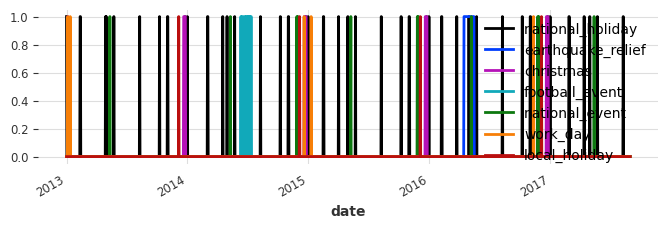

In [114]:
plt.figure(figsize=(8, 2))
holidays_transformed[0].plot()
plt.show()

Promotion

In [115]:
df_promotion = pd.concat([train_df, test_df], axis=0)
df_promotion = df_promotion.sort_values(["store_nbr","family","date"])
df_promotion.tail()

family_promotion_dict = {}

for family in family_list:
    df_family = df_promotion.loc[df_promotion['family'] == family]

    list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                value_cols="onpromotion",
                                fill_missing_dates=True,
                                freq='D')

    for ts in list_of_TS_promo:
        ts = ts.astype(np.float32)

    family_promotion_dict[family] = list_of_TS_promo

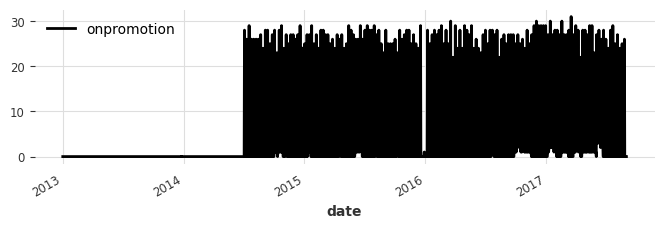

In [116]:
plt.figure(figsize=(8, 2))
family_promotion_dict['EGGS'][0].plot()
plt.show()

In [117]:
"""
moving average in 7 and 28
"""
promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
    promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
    promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaling")

    promo_pipeline = Pipeline([promo_filler,
                                promo_scaler])

    promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])

    # Moving Averages for Promotion Family Dictionaries
    promo_moving_average_7 = MovingAverageFilter(window=7)
    promo_moving_average_28 = MovingAverageFilter(window=28)

    promotion_covs = []

    for ts in promotion_transformed:
        ma_7 = promo_moving_average_7.filter(ts)
        ma_7 = TimeSeries.from_series(ma_7.pd_series())  
        ma_7 = ma_7.astype(np.float32)
        ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
        ma_28 = promo_moving_average_28.filter(ts)
        ma_28 = TimeSeries.from_series(ma_28.pd_series())  
        ma_28 = ma_28.astype(np.float32)
        ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
        promo_and_mas = ts.stack(ma_7).stack(ma_28)
        promotion_covs.append(promo_and_mas)

    promotion_transformed_dict[key] = promotion_covs

100%|██████████| 3/3 [00:00<00:00, 13.62it/s]


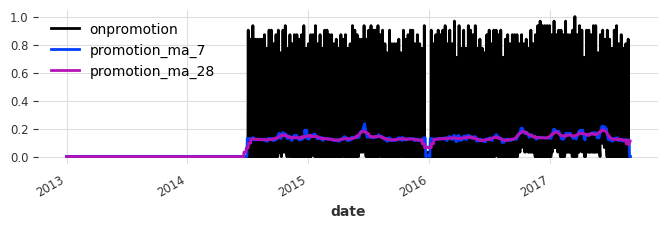

In [118]:
plt.figure(figsize=(8, 2))
promotion_transformed_dict['EGGS'][0].plot()
plt.show()

### Grouping the covariates

Future Covariates

In [119]:
general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

In [120]:
"""
Then for each store, 
we gather the TimeSeries of the holidays with the `general_covariates`
"""
store_covariates_future = []

for store in range(0,len(store_list)):
    stacked_covariates = holidays_transformed[store].stack(general_covariates)  
    store_covariates_future.append(stacked_covariates)

In [121]:
future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):

    promotion_family = promotion_transformed_dict[key]
    covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0, len(promotion_family))]

    future_covariates_dict[key] = covariates_future

100%|██████████| 3/3 [00:00<00:00, 207.87it/s]


In [123]:
display(future_covariates_dict['EGGS'][0].components)

Index(['onpromotion', 'promotion_ma_7', 'promotion_ma_28', 'national_holiday',
       'earthquake_relief', 'christmas', 'football_event', 'national_event',
       'work_day', 'local_holiday', 'year', 'month', 'day', 'dayofyear',
       'dayofweek', 'weekofyear', 'linear_increase', 'dcoilwtico', 'oil_ma_7',
       'oil_ma_28'],
      dtype='object', name='component')

Past Covariates

In [124]:
transaction_df.sort_values(["store_nbr","date"], inplace=True)

TS_transactions_list = TimeSeries.from_group_dataframe(
                                transaction_df,
                                time_col="date",
                                group_cols=["store_nbr"],
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []

for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())
            series = series.astype(np.float32)
            transactions_list.append(series)

transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp('20130102'), end_ts=pd.Timestamp('20170815'))

from datetime import datetime, timedelta

transactions_list_full = []

for ts in transactions_list:
    if ts.start_time() > pd.Timestamp('20130101'):
        end_time = (ts.start_time() - timedelta(days=1))
        delta = end_time - pd.Timestamp('20130101')
        zero_series = TimeSeries.from_times_and_values(
                                times=pd.date_range(start=pd.Timestamp('20130101'), 
                                end=end_time, freq="D"),
                                values=np.zeros(delta.days+1))
        ts = zero_series.append(ts)
        ts = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions")
        transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler")

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

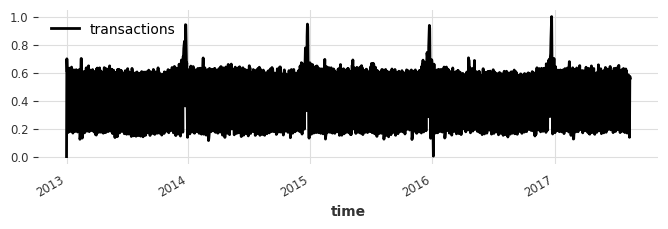

In [125]:
plt.figure(figsize=(8, 2))
transactions_transformed[0].plot()
plt.show()

## Forecasting Model

In [126]:
"""
Hyper params for TiDE
"""
optimizer_kwargs = {
    "lr": 1e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 1000,  # 200
    "accelerator": "cpu",  # default="auto", "gpu", "cpu"
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 40,  # 10
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    "input_chunk_length": 12,  # context window/lookback window
    "output_chunk_length": 1,  # forecast horizon/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 256,
    "random_state": config.seed,
}

In [127]:
n_timeseries = 16

In [128]:
display("Training...")

tide_models_dict = {}
for family in tqdm(family_list):

    series_list = scaled_series_dict[family]
    training_data = [series for series in series_list]

    TCN_covariates = future_covariates_dict[family]
    train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0, len(training_data))]

    # Initialize a model instance
    model = TiDEModel(
        **common_model_args,
        model_name='sales_forecasting',
        use_reversible_instance_norm=False,
        use_static_covariates=True,
    )

    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    # training
    model.fit(
        series=train_sliced,
        # val_series=val_series[:n_timeseries],
        past_covariates=transactions_transformed,
        # val_past_covariates=past_cov_series,
        future_covariates=TCN_covariates,
        # val_future_covariates=past_cov_series,
        verbose=False,
    )

    tide_models_dict[family] = model

    break


'Training...'

  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: The provided sequence of target series must have the same length as the provided sequence of covariate series.